# An NLP cleaning exercise

Here I wrangle tweets into a useable dataset so that we can visualise it and potentially glean some insights related to epidemic modelling. I focus on interpretable summaries and trends over time.

Three records were removed from the dataset before this analysis was run since they had an odd number of columns.

# Data cleaning

There is nothing particularly special about the data cleaning section...

In [1]:
from sklearn.decomposition import LatentDirichletAllocation
import pandas as pd
import ast

In [2]:
dtype = {
    'user_location': 'str',
    'user_description': 'str',
    'user_followers': float,
    'user_friends': float,
    'user_favourites': float,
    'user_verified': 'str',
    'date': 'str',
    'text': 'str',
    'hashtags': 'object'
}

# 3 tweets removed because they had different columns
tweets = pd.read_csv(
    'vax_tweets_cleaned.csv',
    usecols=range(1, 10),
    dtype=dtype
)

In [3]:
# set zeros
tweets.user_followers = tweets.user_followers.fillna(0).astype(int)
tweets.user_friends = tweets.user_friends.fillna(0).astype(int)
tweets.user_favourites = tweets.user_favourites.fillna(0).astype(int)

# parse dates
tweets.date = pd.to_datetime(tweets.date)

In [4]:
# verified
tweets.user_verified = tweets.user_verified.str.lower() == 'true'

In [5]:
#hashtags
tweets.hashtags = tweets.hashtags.fillna('[]').apply(ast.literal_eval)

# Summary counts

I count:
 * 50 most occuring locations in dataset
 * log spread of followers, friends and favourites
 * percentage of tweets from verified users
 * number of tweets over time
 * 50 most occuring hashtags in the dataset

In [6]:
tweets.user_location.value_counts()[:50]

Bengaluru, India           4283
India                      1941
United States              1379
USA                        1137
London, England            1089
Estados Unidos              945
London                      894
United Kingdom              676
Canada                      671
New Delhi, India            665
Washington, DC              629
Chicago, IL                 579
Mumbai, India               525
New York, NY                522
Australia                   514
UK                          473
Los Angeles, CA             451
England, United Kingdom     427
Toronto, Ontario            359
California, USA             332
London, UK                  307
Boston, MA                  304
Ireland                     301
New York                    296
Houston, TX                 284
New Delhi                   276
Philadelphia, PA            266
Texas, USA                  264
Ottawa, Ontario             262
New York, USA               260
Atlanta, GA                 257
Tristan 

In [7]:
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x7f22af065990>,
 [Text(1, 0, 'user_followers'),
  Text(2, 0, 'user_friends'),
  Text(3, 0, 'user_favourites')])

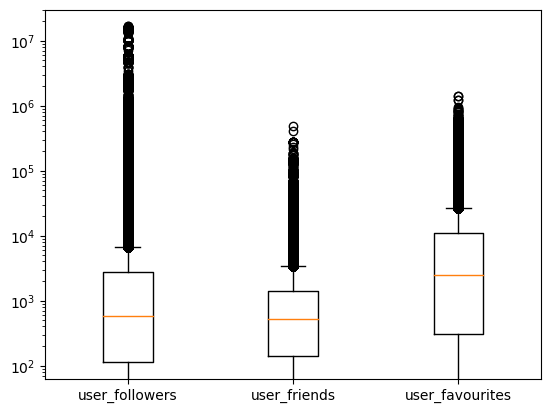

In [80]:
plt.boxplot(tweets[['user_followers', 'user_friends', 'user_favourites']])
plt.yscale('log')
plt.xticks(ticks=range(1, 4), labels=['user_followers', 'user_friends', 'user_favourites'])

In [9]:
f'{tweets.user_verified.sum()/len(tweets) * 100.:.2f}% of the dataset are verified'

'9.80% of the dataset are verified'

Text(0, 0.5, 'Number of tweets')

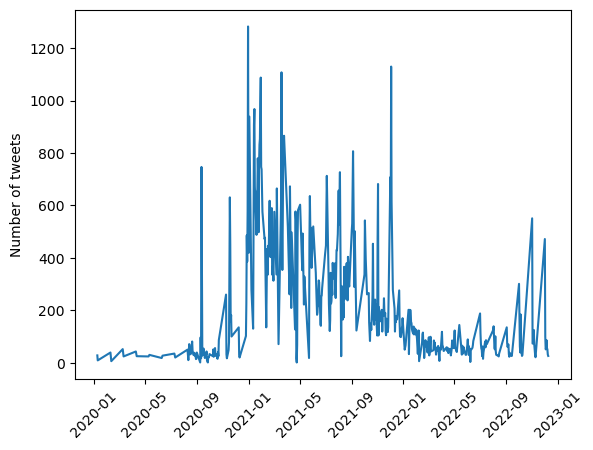

In [10]:
tweets_per_day = tweets.date.dt.date.value_counts().sort_index()
plt.plot(tweets_per_day)
plt.xticks(rotation = 45)
plt.ylabel('Number of tweets')

In [83]:
hashtags = tweets[['date', 'hashtags']].explode('hashtags')
hashtags.hashtags.str.lower().value_counts()[:50]

covidvaccine          76751
covid19               18462
covid                  5679
bengaluru              4231
covishield             4217
vaccine                4064
coronavirus            3960
covaxin                3178
covid_19               2461
vaccination            1937
pfizer                 1917
getvaccinated          1626
vaccinated             1588
sputnikv               1526
covidvaccination       1514
urban                  1445
rural                  1401
bbmp                   1380
vaccines               1149
vaccineswork           1144
news                   1133
health                 1127
moderna                1028
covid19vaccine         1008
covidiots              1007
india                   981
corona                  933
covidisnotover          903
astrazeneca             870
deltavariant            833
pandemic                798
breakingnews            785
auspol                  741
covid19vic              682
covid19uk               669
booster             

# Text content

These word counting methods show:

 * The most frequent words in tweets in our dataset
 * The most frequent words in user profiles in our dataset
 * Ten topics in our dataset, represented by 3 strongly tied tweets (estimated by LDA)
 * The topic trend over time, estimated by the "topic strength", aggregated by day
 
 Words are counted based on their 'lemma', a base representation of the word, to reduce sparsity.
 
 "topic strength" is the sum of the probabilities of topic membership over a set of tweets
 
 Topic trends were gaussian smoothed to aid any interpretation

In [ ]:
!pip install spacy
!python -m spacy download en_core_web_lg

In [12]:
import spacy
nlp = spacy.load("en_core_web_lg")

In [13]:
with nlp.select_pipes(enable=['tagger', 'attribute_ruler', 'lemmatizer']):
    text_docs = list(nlp.pipe(tweets.text.fillna(''), n_process=-1))

In [20]:
with nlp.select_pipes(enable=['tagger', 'attribute_ruler', 'lemmatizer']):
    user_docs = list(nlp.pipe(tweets.user_description.fillna('').unique(), n_process=-1))

In [14]:
tokens = pd.DataFrame(
    [
        {'doc': i, 'token': token.lemma_}
        for (i, doc) in enumerate(text_docs)
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
)

In [15]:
tokens.token.value_counts()[:50]

covidvaccine     76411
vaccine          23290
covid            14072
slots             9403
amp               7654
vaccinated        7479
people            7344
vaccination       7334
dose              5916
vaccines          5836
free              5635
today             5319
coronavirus       4891
got               4741
paid              4371
covishield        4366
availability      4332
pfizer            4323
bengaluru         4264
health            4133
getting           3781
covaxin           3432
new               3271
doses             3251
news              3039
india             3008
shot              2949
booster           2909
need              2853
like              2758
second            2719
know              2642
day               2486
time              2189
moderna           2038
jab               2025
year              1959
good              1946
pandemic          1931
world             1869
thank             1849
great             1767
children          1767
safe       

In [21]:
user_tokens = pd.DataFrame(
    [
        {'doc': i, 'token': token.lemma_}
        for (i, doc) in enumerate(user_docs)
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ]
)

In [22]:
user_tokens.token.value_counts()[:50]

health        3976
news          3189
views         2915
love          2467
life          2246
lover         2007
tweets        1914
fan           1856
mom           1810
world         1742
writer        1742
care          1697
people        1598
proud         1558
opinions      1483
music         1439
social        1412
wife          1317
science       1281
politics      1262
follow        1233
medical       1230
twitter       1227
community     1170
advocate      1156
time          1143
media         1139
author        1137
director      1129
account       1109
research      1071
new           1056
husband       1052
family        1038
public        1036
business      1022
official      1000
father         966
like           966
sports         962
healthcare     946
personal       939
journalist     921
services       915
political      905
live           902
good           887
student        882
enthusiast     861
living         856
Name: token, dtype: int64

In [26]:
import numpy as np

In [31]:
from sklearn.feature_extraction.text import CountVectorizer
vectoriser = CountVectorizer()

clean_text_corpus = [
    ' '.join([
        token.lemma_
        for token in doc
        if not token.is_stop and not token.is_punct and token.is_alpha
    ])
    for doc in text_docs
]

count_embeddings = vectoriser.fit_transform(clean_text_corpus)

In [ ]:
topic_model = LatentDirichletAllocation()
topic_embeddings = topic_model.fit_transform(count_embeddings)
topics = pd.DataFrame(topic_embeddings, columns=[f'topic_{i}' for i in range(10)])
tweets_topics = pd.concat([tweets, topics], axis=1)

In [47]:
for i in range(10):
    print('----')
    print(f'Most representative tweets in topic {i}')
    print('----')
    for t in tweets_topics.sort_values(f'topic_{i}', ascending=False).text[:3]:
        print(t)
        print('----')

----
Most representative tweets in topic 0
----
#COVID19TN
Covid positive cases today in TN 1756 Individuals Tested 155199 TPR in TN 1.13%. TPR yesterday 1.31%. TPR dipped. Testing increased. Fatality is the area of concern. Follow appropriate covid behavior to avoid third wave. #CovidVaccine #COVID #Corona #DeltaPlusVariant https://t.co/crObA8If7G
----
#COVID19TN
Covid positive cases today in TN 1859 Individuals Tested 156359 TPR in TN 1.19%. TPR yesterday 1.13%. TPR increases. Testing increased. Fatality is the area of concern. Follow appropriate covid behavior to avoid third wave. #CovidVaccine #COVID #Corona #DeltaVariant https://t.co/9JheoSOp0q
----
#COVID19TN
Covid positive cases today in TN 3867 Individuals Tested 156330 TPR in TN 2.45%. TPR dipped. TPR yesterday 2.53%. Fatality dipped and is the area of concern. Follow appropriate covid protocols to avoid third wave #CovidVaccine #COVID #Corona #DeltaPlusVariant https://t.co/BbguDGSX5e
----
----
Most representative tweets in to

In [ ]:
from scipy.ndimage import gaussian_filter1d

Text(0.5, 1.0, 'Gaussian smoothed topic strength over time')

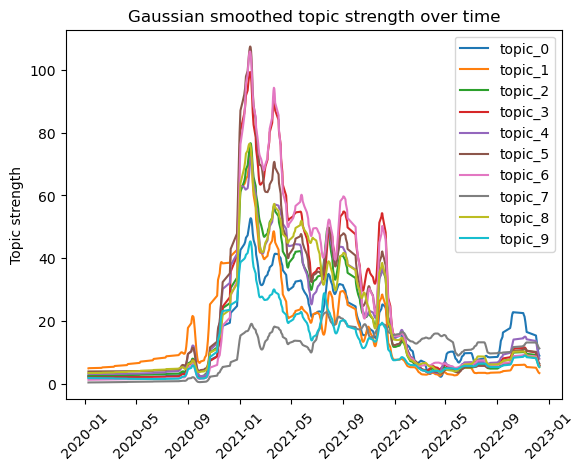

In [68]:
topic_trends = tweets_topics.groupby(tweets.date.dt.date).agg({f'topic_{i}': sum for i in range(10)}).sort_index()
plt.plot(topic_trends.apply(lambda x: gaussian_filter1d(x, 5), axis=0))
plt.legend(topic_trends.columns)
plt.xticks(rotation = 45)
plt.ylabel('Topic strength')
plt.title('Gaussian smoothed topic strength over time')

Text(0.5, 1.0, 'Topic strength over time, normalised by tweets per day')

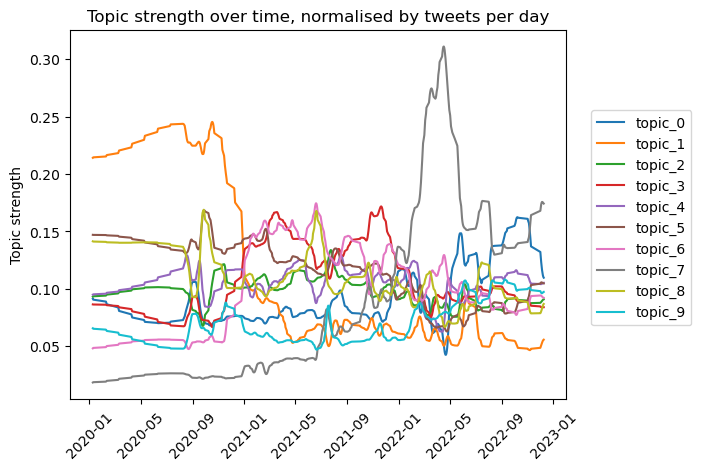

In [76]:
topic_trends = tweets_topics.groupby(tweets.date.dt.date).agg({f'topic_{i}': sum for i in range(10)}).sort_index()
plt.plot(topic_trends.apply(lambda x: gaussian_filter1d(x / tweets_per_day, 5), axis=0))
plt.legend(topic_trends.columns, loc=(1.05,.2))
plt.xticks(rotation = 45)
plt.ylabel('Topic strength')
plt.title('Topic strength over time, normalised by tweets per day')

In [88]:
symptoms = {
    'temperature',
    'shivering',
    'chills',
    'cough',
    'coughing',
    'anosmia',
    'smell',
    'taste',
    'breathe',
    'breath',
    'tired',
    'exhausted',
    'fatigue',
    'ache',
    'aching',
    'headache',
    'migrane',
    'throat',
    'nose',
    'appetite',
    'hungry',
    'diarrhoea',
    'sick',
    'nauseous'
}
symptoms_lemma = {nlp(t)[0].lemma_ for t in symptoms}
symptomatic_tweets = tweets.loc[tokens[tokens.token.isin(symptoms_lemma)].doc]

In [98]:
symptomatic_topic_model = LatentDirichletAllocation()
symptomatic_topic_embeddings = topic_model.fit_transform(count_embeddings[tokens[tokens.token.isin(symptoms_lemma)].doc])
symptomatic_topics = pd.DataFrame(symptomatic_topic_embeddings, columns=[f'topic_{i}' for i in range(10)])
symptomatic_tweets_topics = pd.concat([symptomatic_tweets.reset_index(), symptomatic_topics], axis=1)

In [100]:
for i in range(10):
    print('----')
    print(f'Most representative tweets in topic {i}')
    print('----')
    for t in symptomatic_tweets_topics.sort_values(f'topic_{i}', ascending=False).text[:3]:
        print(t)
        print('----')

----
Most representative tweets in topic 0
----
@HeatherMagness @RealMattCouch Every Democrat.

Just to watch republican voters get in a tin tube and breath each o… https://t.co/ZBWStJ5vm4
----
God is still on the throne. Don't get tired of praying. Feed your faith.
#prayer #tuesdaymotivations #tuesdayvibe… https://t.co/W86MPrtC7H
----
So if these vaccinations are required to to to school, why can't a #Covidvaccine be required?
Diphtheria, tetanus, and whooping cough (pertussis) (DTaP)
Haemophilus influenzae type b (Hib)
Polio (IPV)
Pneumococcal (PCV)
Rotavirus (RV)
Hepatitis B (HepB)
----
----
Most representative tweets in topic 1
----
#CovidVaccine experience (Moderna):
Dose1: Painless! Didn’t even feel it. Arm sore 2-3 days. Delayed effects day 8-10: strong body aches + mild fatigue/arm rash. 
Dose2: Felt it. Arm sore + very fatigued + mild G/I issues for 3 days. After that I felt great!  💯 Worth it! https://t.co/hqBZaxhw8h
----
Gonna try and stream just a little with no webcam even

In [106]:
list(symptomatic_tweets_topics[((symptomatic_tweets_topics.topic_4 > 0.7) | (symptomatic_tweets_topics.topic_1 > 0.7))].text)[:5]

['Day 1 following #2nd dose of @moderna_tx vaccine finds me feeling a little achy. Still no fever and no headache but… https://t.co/QcdvE2cTu5',
 'My mom got her second vaccine yesterday. Said she was tired but that was it. #COVIDVaccine',
 "update post covid jab : yes, I do have a bit of a temperature and flu-like symptoms but I'm working W@H.\nHowever, I… https://t.co/EAIrU40sNr",
 "Got my 2nd #COVIDvaccine yesterday! Felt great last PM &amp; but fever/chills/body ache this AM. Hey, it's better than… https://t.co/5WTrrLlg9f",
 'Had my 2nd dose of the Pfizer vaccine today. Doing good just feeling tired and my arm is sore. \n#Pfizervaccine… https://t.co/wk5y2F67s0']